## Ari Boyarsky
## OSM Econ PSET 5


In [119]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import special
from scipy.stats import norm
from scipy.integrate import quad
from scipy.linalg import pinv
import requests

### Question 1

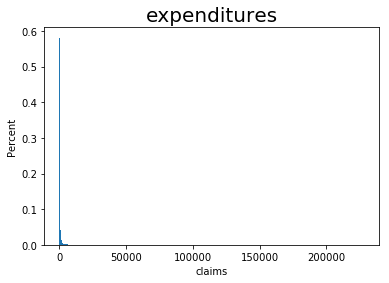

In [120]:
data = np.loadtxt( 'clms.txt')
weights = (1 / data.shape[0]) * np.ones_like(data)
count, bins, ignored = plt.hist(data, 1000, weights=weights)
plt.title('expenditures', fontsize=20)
plt.xlabel('claims')
plt.ylabel('Percent')
plt.show()

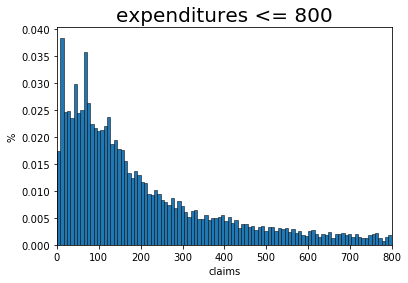

In [14]:
part = np.asarray([x for x in data if x <=800])
weights = (1 / data.shape[0]) * np.ones_like(part)
n, bins, ignored = plt.hist(data_part, 100, weights=weights, edgecolor='black',
                                linewidth=0.5)
plt.title('expenditures <= 800', fontsize=20)
plt.xlabel('claims')
plt.ylabel('%')
plt.xlim(0, 800)
plt.show()

In [22]:
beta_data = (data.var())/data.mean()
alpha_data = data.mean()/beta_data  
params = (alpha_data, beta_data)

def GA_pdf(xvals, alpha, beta):
    pdf_vals = 1/((beta ** alpha) * special.gamma(alpha)) * (xvals ** (alpha - 1)) * np.exp(-xvals/beta)
    return pdf_vals

def log_lik_GA(xvals, alpha, beta):
  
    pdf_vals = GA_pdf(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit(params, args):
    
    alpha, beta = params
    xvals = args
    log_lik_val = log_lik_GA(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [25]:
ga_args = data
results = opt.minimize(crit, params, args=(ga_args), method ='L-BFGS-B', bounds= ((1e-6, None), (1e-6, None)))
alpha_ga, beta_ga = results.x
print(results)

      fun: 82076.451605664712
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00291038,  0.09022187])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([  2.21755310e-01,   2.19110647e+04])


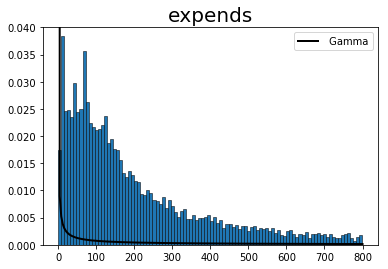

In [35]:
part = np.asarray([x for x in data if x <=800])
weights = (1 / data.shape[0]) * np.ones_like(part)
n, bins, ignored = plt.hist(data_part, 100, weights=weights, edgecolor='black',
                                linewidth=0.5)
plt.title('expends', fontsize=20)
x = np.linspace(1e-10, 800, 200)
y = GA_pdf(x, alpha_ga, beta_ga)
plt.plot(x, y,'k-',
         linewidth=2, label=' Gamma')
plt.ylim(0, 0.04)
plt.legend()
plt.show()

In [46]:
beta_guess = beta_ga
alpha_guess = alpha_ga
m_guess = 1
params = (alpha_guess, beta_guess, m_guess)

def GG_pdf(xvals, alpha, beta, m):

    pdf_vals = m/((beta**alpha)*special.gamma(alpha/m))*(xvals**(alpha - 1))*np.exp(-(xvals/beta)**m)
    return pdf_vals

def log_lik_GG(xvals, alpha, beta, m):
  
    pdf_vals = m/((beta**alpha)*special.gamma(alpha/m))*(xvals**(alpha - 1))*np.exp(-(xvals/beta)**m)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit_GG(params, args):
    
    alpha, beta, m = params
    xvals = args
    log_lik_val = log_lik_GG(xvals, alpha, beta, m)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [48]:
gg_args = data
results = opt.minimize(crit_GG, params, args=(gg_args), method ='L-BFGS-B', bounds= ((1e-6, None), (1e-6, None), (1e-6, None)))
alpha_gg, beta_gg, m = results.x
print(results)

      fun: 82076.446842131147
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.36961865,  0.09022187, -1.18161552])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 2
   status: 0
  success: True
        x: array([  2.21751911e-01,   2.19110644e+04,   9.97019440e-01])


In [52]:
q_guess = 6000
a_guess = m
b_guess = q_guess**(1/a_guess)*beta_gg
p_guess = alpha_gg/m

def GB2_pdf(xvals, a, b ,p, q):
    x = a*xvals**(a*p-1)
    y = (b**(a*p))*special.beta(p,q)*((1+(xvals/b)**a)**(p+q))
    pdf_vals = x/y
    return pdf_vals

def log_lik_GB2(xvals, a, b, p, q):
  
    pdf_vals = GB2_pdf(xvals, a, b, p, q)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit_GB2(params, args):
    
    a, b, p, q = params
    xvals = args
    log_lik_val = log_lik_GB2(xvals, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [54]:
params = (a_guess, b_guess, p_guess, q_guess) 
gb2_args = data
results = opt.minimize(crit_GB2, params, args=(gb2_args), method ='L-BFGS-B', bounds=((1e-6, None), (1e-6, None), (1e-6, None), (1e-6, None)))
a_gb2, b_gb2, p_gb2, q_gb2 = results.x
print(results)

      fun: 76392.187422371353
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-281.57519409,    0.        ,  -20.02634574,   -5.78729669])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 145
      nit: 13
   status: 0
  success: True
        x: array([  6.81091325e-01,   1.34930273e+08,   1.05164173e+00,
         5.99713737e+03])


In [58]:
GB2 = log_lik_GB2(data, a_gb2, b_gb2, p_gb2, q_gb2)
GG = log_lik_GG(data, alpha_gg, beta_gg, m)
GA = log_lik_GA(data, alpha_ga, beta_ga)
GG_val = abs(2 * (GG - GB2))
GA_val = abs(2 * (GA - GB2))
pval_GG = 1.0 - sts.chi2.cdf(GA_val, 4)
pval_GA = 1.0 - sts.chi2.cdf(GA_val, 4)

In [59]:
print(pval_GG, pval_GA)

0.0 0.0


### Question 2

In [60]:
alpha_init = 0.4
rho_init = 0.7
mu_init = 8
sigma_init = 0.1
params_init = (alpha_init, rho_init, mu_init, sigma_init)
data = np.loadtxt('MacroSeries.txt', delimiter=",")
beta = 0.99
c = data[:, 0]
k = data[:, 1]
w = data[:, 2]
r = data[:, 3]

In [62]:
def get_z(w, k, alpha):
    return np.log(w) - np.log(1 - alpha) - alpha * np.log(k)

def logpdf(z, rho, mu, sigma):
    z[0] = mu
    mean = rho * z[:-1] + (1 - rho) * mu
    return norm.logpdf(z, np.hstack([mu, mean]), sigma)
def crit1(params, *args):
   
    alpha, rho, mu, sigma = params
    w, k  = args
    return -(logpdf(get_z(w, k, alpha), rho, mu, sigma).sum())

In [78]:
args1 = (w, k)
res1 = opt.minimize(crit1, params_init, args=(args1), method ='L-BFGS-B', bounds=((1e-6, 1-1e-6), (-1+1e-6, 1-1e-6),(1e-6, None), (1e-6, None)))
alpha1, rho1, mu1, sigma1 = results1.x
print(res1)

      fun: -83.689364309487161
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.11950239e+01,  -1.56319402e-05,   2.70006240e-05,
        -4.10693701e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 285
      nit: 31
   status: 0
  success: True
        x: array([  0.999999  ,   0.98254482,  16.28480909,   0.10478628])


In [79]:
res1.hess_inv.todense()

array([[  1.00000000e+00,  -8.50289271e-02,  -1.69023332e+01,
         -9.61878007e-02],
       [ -8.50289271e-02,   7.98531335e-03,   1.43825601e+00,
          8.27527979e-03],
       [ -1.69023332e+01,   1.43825601e+00,   2.85702240e+02,
          1.62536899e+00],
       [ -9.61878007e-02,   8.27527979e-03,   1.62536899e+00,
          9.60009761e-03]])

In [75]:
def get_z(r, k, alpha):
    return np.log(r) - np.log(alpha) - (alpha - 1) * np.log(k)
def crit2(params, *args):
   
    alpha, rho, mu, sigma = params
    r, k  = args
    return -(logpdf(get_z(r, k, alpha), rho, mu, sigma).sum())

In [76]:
args2 = (r, k)
res2 = opt.minimize(crit2, params_init, args=(args2), method ='L-BFGS-B',bounds=((1e-6, 1-1e-6), (-1+1e-6, 1-1e-6),(1e-6, None), (1e-6, None)))
alpha2, rho2, mu2, sigma2 = results2.x
print(res2)

      fun: -95.552985137573359
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.46087586e-03,  -2.41584530e-05,  -9.37916411e-05,
        -8.07176548e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 270
      nit: 37
   status: 0
  success: True
        x: array([ 0.85063442,  0.51753071,  2.50436508,  0.09306391])


In [77]:
res2.hess_inv.todense()

array([[  5.64051911e+00,  -4.54112563e+01,  -9.83651767e+01,
          1.55040908e+00],
       [ -4.54112563e+01,   3.69194794e+02,   7.92233814e+02,
         -1.26167466e+01],
       [ -9.83651767e+01,   7.92233814e+02,   1.71541984e+03,
         -2.70490484e+01],
       [  1.55040908e+00,  -1.26167466e+01,  -2.70490484e+01,
          4.31261968e-01]])

In [80]:
z = get_z(1, 7500000, alpha2)
mean = rho2 * 10 + (1 - rho2) * mu2
print(1-norm.cdf(z, mean, sigma2))

1.0


### Question 3

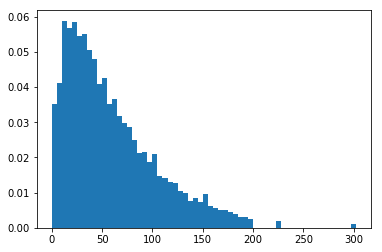

In [109]:
data = np.loadtxt('usincmoms.txt')
left=data[:,1]/1000
plt.bar(left, np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20]), 5)
b=np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20])
plt.show()

In [85]:
xvals=data[:,1]
data_moments=data[:,0]
W = np.diag(data_moments)

In [86]:
def model_moments_ln(xvals, mu, sigma):
    return sts.lognorm.pdf(xvals, s = sigma, scale = np.exp(mu))
def err_vec(xvals, data_moments , mu, sigma, simple=False):
    g = lambda x: model_moments_ln(x, mu, sigma)
    model_moments = np.zeros(len(xvals))
    for i in range(len(xvals)):
        model_moments[i] = quad(g, xvals[i]-2500, xvals[i] + 2500)[0] 
    if simple:
        err_vec = model_moments - data_moments
    else:
        err_vec = (model_moments - data_moments) / data_moments
    return err_vec
def crit(params, *args): 
    mu, sigma = params
    xvals, data_moments, W = args
    err = err_vec(xvals, data_moments, mu, sigma)
    return np.dot(np.dot(err.T, W), err) 

In [88]:
mean = (xvals * data_moments).sum()
sd = ((xvals - mean) ** 2 * data_moments).sum()

mu_init = np.log(mean/(np.sqrt(1 + sd/mean ** 2)))
sigma_init = np.sqrt(np.log(1 + sd/mean ** 2))

bnds = ((None, None), (1e-5, None))
params_init = (mu_init, sigma_init)

ln_args = (xvals, data_moments, W)
res = opt.minimize(crit, params_init, args=(ln_args), bounds = bnds)
print(res)
mu_ln, sigma_ln = res.x

      fun: 0.062992115913488675
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.89747132e-06,   1.10744747e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 6
   status: 0
  success: True
        x: array([ 10.86071336,   1.0370576 ])


In [89]:
alpha_init  = 3
beta_init = 20000
def model_moments_ga(xvals, alpha, beta):
    return 1/((beta ** alpha) * special.gamma(alpha)) * (xvals ** (alpha - 1)) * np.exp(-xvals/beta)

def err_vec_ga(xvals,  data_moments, alpha, beta, simple=False):
    g = lambda x: model_moments_ga(x, alpha, beta)
    model_moments = np.zeros(len(xvals))    
    for i in range(len(xvals)):
        model_moments[i] = quad(g, xvals[i]-2500, xvals[i] + 2500)[0]
    if simple:
        err_vec = model_moments - data_moments
    else:
        err_vec = (model_moments - data_moments) / data_moments
    return err_vec

def crit_ga(params, *args):
    alpha, beta = params
    xvals, frequency, W = args
    err = err_vec_ga(xvals,  data_moments, alpha, beta)
    return np.dot(np.dot(err.T, W), err) 

In [90]:
params = (alpha_init, beta_init)
ga_args = (xvals,  data_moments, W)
res2 = opt.minimize(crit_ga, params, args=(ga_args), bounds = ((1e-5, None), (1e-5, None)))
print(res2)
alpha_ga, beta_ga = res2.x

      fun: 0.04402459026937057
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.07382461e-06,   0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 108
      nit: 28
   status: 0
  success: True
        x: array([  1.40612154e+00,   4.55959341e+04])


C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


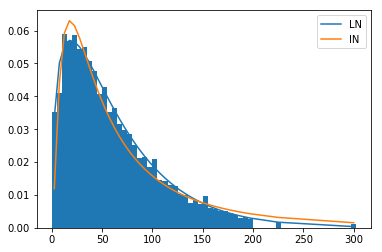

In [111]:
left=data[:,1]/1000
plt.bar(left, np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20]), 5)
b=np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20])

x=left*1000
g = lambda x: model_moments_ga(x, alpha_ga, beta_ga)
y = np.zeros(len(xvals))
for i in range(len(xvals)):
        y[i] = quad(g, x[i]-2500, x[i] + 2500)[0] 
x=x/1000
plt.plot(x, y, label="LN")
x=left*1000
g = lambda x: model_moments_ln(x, mu_ln, sigma_ln)
y = np.zeros(len(xvals))
for i in range(len(xvals)):
        y[i] = quad(g, x[i]-2500, x[i] + 2500)[0] 
x=x/1000
plt.plot(x, y,label="IN")
plt.legend()
plt.show()

In [96]:
W = np.identity(42)
ga_args1 = (xvals, data_moments, W)
res2 = opt.minimize(crit_ga, params, args=(ga_args1), bounds = ((1e-5, None), (1e-5, None)))
print(res2)
alpha_ga2, beta_ga2 = res2.x

      fun: 2.1244347781120916
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00040639,  0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 114
      nit: 28
   status: 0
  success: True
        x: array([  1.40909586e+00,   4.46597296e+04])


In [100]:
e = err_vec_ga(xvals, data_moments, alpha_ga2, beta_ga2)
O = np.outer(e.T, e) 
W = pinv(O)
params = (3, 20000)
ga_args3 = (xvals, data_moments, W)
results3 = opt.minimize(crit_ga, params, args=(ga_args3), bounds = ((1e-5, None), (1e-5, None)))
print(results3)
alpha_ga3, beta_ga3 = results3.x

      fun: -80240082133.109741
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.52169095e+12,  -2.61871338e+07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 126
      nit: 20
   status: 0
  success: True
        x: array([  1.47894820e+00,   4.04104402e+04])


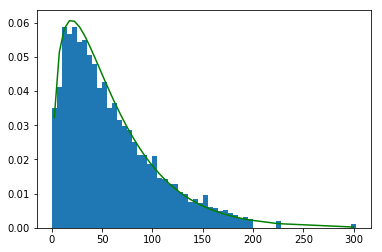

In [110]:
plt.bar(left, np.hstack([data[:, 0][:-2], data[:, 0][-2]/10, data[:, 0][-1]/20]), 5)
x=left*1000
g = lambda x: model_moments_ga(x,alpha_ga3, beta_ga3)
y = np.zeros(len(xvals))
for i in range(len(xvals)):
        y[i] = quad(g, x[i]-2500, x[i] + 2500)[0] 
x=x/1000
plt.plot(x, y, 'g')

plt.show()

### Question 4

In [113]:
data = np.loadtxt('MacroSeries.txt', delimiter=",")
c = data[:, 0]
k = data[:, 1]
w = data[:, 2]
r = data[:, 3]

In [115]:
def get_z(r,k,alpha):
    return np.log(r) - np.log(alpha) - (alpha - 1) * np.log(k)
def data_moments(c, k, w, r, alpha, beta, rho, mu):
    z = get_z(r, k, alpha)
    eq7 = z[1:] - rho * z[:-1] - (1 - rho) * mu
    eq8 = (z[1:] - rho * z[:-1] - (1 - rho) * mu) * z[:-1]
    eq9 = beta * alpha * np.exp(z[1:]) * k[1:] ** (alpha - 1) * c[:-1]/c[1:] - 1
    eq10 = (beta * alpha * np.exp(z[1:]) * k[1:] ** (alpha - 1) * c[:-1]/c[1:] - 1) * w[:-1]
    return eq7.mean(), eq8.mean(), eq9.mean(), eq10.mean()
def err_vec(c, k, w, r, alpha, beta, rho, mu, simple = True):
    mo_moments = np.zeros(4)
    da_moments = np.array(data_moments(c, k, w, r, alpha, beta, rho, mu)).reshape(1, 4)
    if simple:
        err_vec = (mo_moments - da_moments)[0]
    else:
        err_vec = (mo_moments - da_moments) / da_moments
    return err_vec
def crit(params, *args):
    alpha, beta, rho, mu = params
    c, k, w, r, weight  = args
    err = err_vec(c, k, w, r, alpha, beta, rho, mu)
    return np.dot(np.dot(err.T, weight), err) 

In [117]:
weight = np.identity(4)
alpha_init = 0.4
beta_init = 0.8
rho_init = 0.7
mu_init = 9
params = (alpha_init, beta_init, rho_init, mu_init)
args = (c, k, w, r, weight)
results = opt.minimize(crit, params, args=(args), bounds = ((1e-5, 1-1e-5), (1e-5, 1-1e-5), (-1+1e-5, 1-1e-5), (1e-5, None)), method = 'L-BFGS-B')
print(results)

      fun: 0.002171727328676759
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.58156718e-02,   2.03044618e+03,   4.88148150e-05,
         8.97812553e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 235
      nit: 28
   status: 0
  success: True
        x: array([ 0.47250576,  0.99      ,  0.71564474,  9.00356726])
